<a href="https://colab.research.google.com/github/smomtahe/Brain_Tumor_Project/blob/main/GANs_DNNs_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout
import os, io,zipfile,time
from PIL import Image
import tqdm
import cv2
from pathlib import Path
import joblib
from keras.preprocessing import image

from tensorflow.keras.layers import Add, Dense, ReLU, Reshape, LeakyReLU



In [ ]:
# load data - data has training (tumor,no-tumor) and test (tumor,no-tumor) datasets

zip_file_path=("/content/MRIBrainTumor.zip")
extracted_dir=("/content/extracted_data")
!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [ ]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# path_to_no_tumor_directory and "path_to_pituitary_tumor_directory"
no_tumor_path = Path("/content/extracted_data/Training/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Training/pituitary_tumor")

images = []
labels = []

for img_path in no_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(0)

for img_path in pituitary_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224),color_mode='grayscale')
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(1)

xtrain = np.array(images)
ytrain = np.array(labels)


In [ ]:
ytrain.shape #(1222,)
xtrain.shape  #(1222, 224, 224, 1)

(1222, 224, 224, 1)

In [ ]:
#scale between -1 and 1  (negative: fake images by generator)
xtrain=xtrain.astype('float32')
xtrain=(xtrain-127.5)/127.5


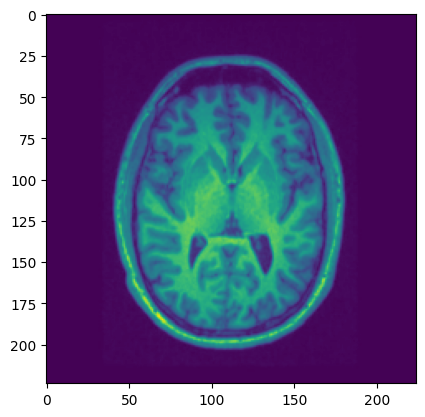

In [ ]:
plt.imshow(xtrain[10])

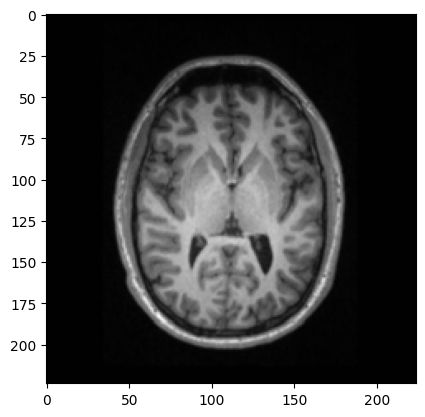

In [ ]:
plt.imshow(xtrain[10].squeeze(),cmap='gray')

In [ ]:
buffer_size=1222  #shuffle images
batch_size=32  #128
train_dataset=tf.data.Dataset.from_tensor_slices(xtrain).shuffle(buffer_size).batch(batch_size)

# creates a dataset from the training images, shuffles the dataset, and batches the shuffled elements into batches of a specified size, making it suitable for training the model.
# creates a tensorflow dataset (train_dataset) from a tensor of training images by slicing it along the first dimension- each element of the dataset will correspond to one element of the tensor (xtrain), preserving their order.

In [ ]:
# Generator

def generator_model():
  model=tf.keras.Sequential()

  # First hidden layer
  model.add(Dense(64, input_dim=100)) # for generator
  model.add(ReLU())

  # Second hidden layer
  model.add(Dense(128))
  model.add(ReLU())

  # Third hidden layer
  model.add(Dense(256))
  model.add(ReLU())

  # Output layer - size 50176 pixels (=224*224)
  # Activation 'tanh' produces outputs in the range -1 to 1 (same range as the images in the real dataset)
  model.add(Dense(50176, activation='tanh'))

  # Generator produces realistic images: flatten 50176 pixels of our generator image
  # Reshape to be the same as a real image
  model.add(Reshape((224,224, 1)))

  return model

generator=generator_model()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                6464      
                                                                 
 re_lu_15 (ReLU)             (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 re_lu_16 (ReLU)             (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               33024     
                                                                 
 re_lu_17 (ReLU)             (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 50176)            

In [ ]:
# generate a noise variable vector to feed in the generator model
noise=tf.random.normal([1,100])  # generate Gaussian noise: vector size is 100= input dimension of our generator model
generated_image=generator(noise,training=False)  # False: see the generated img looks like
generated_image.shape  # TensorShape([1, 224, 224, 1]) 1 img batch size 1 - 28*28 1 chanel

TensorShape([1, 224, 224, 1])

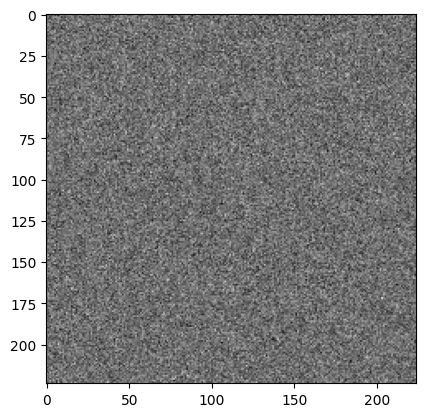

In [ ]:
# plot generated img (generator has not trained yet)
plt.imshow(generated_image[0,:,:,0],cmap="gray")

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(224,224,1)))
    model.add(layers.Flatten()) # flatten input img: imgs represented as a single dimensional vector : passed in the dense layers
    # 3 Dense layers
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2)) # slight gradient for input values below zero : controlled by the input argument (o.2) that we pass into LR
    model.add(layers.Dropout(0.5)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid')) # single probability score: represent the prob that input img is real -sigmoid : prob score : 0-1

    return model
# input img fed into real or fake

In [ ]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_40 (Dense)            (None, 256)               12845312  
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_13 (Dropout)        (None, 128)             

In [ ]:
discriminator=discriminator_model()
output=discriminator(generated_image)
print(output)
# img (noise) from untrained generated model and pass this through the untrained discriminator ->  probability score: % 49

tf.Tensor([[0.5037169]], shape=(1, 1), dtype=float32)


In [ ]:
bce=tf.keras.losses.BinaryCrossentropy()  # loss function

In [ ]:
def discriminator_loss(real_output,fake_output):
  # 2 classes 1: real and 0:fake # imgs from real dataset classfied as real
  real_loss=bce(tf.ones_like(real_output),real_output) # compare output of discriminator to a tensor of 1s, this loss = real loss of the discriminator
  fake_loss=bce(tf.zeros_like(fake_output),fake_output) # tensor of 0s #fake binary crossentropy loss
  total_loss=real_loss+fake_loss # try to min total loss or max probabilty real imgs classifed as real and generated imgs are classfied as fake
  return total_loss


In [ ]:
# Traning GANs # 2 Networks
# generator loss
def generator_loss(fake_output):
  gen_loss=bce(tf.ones_like(fake_output),fake_output) # input is fake_output = output of discriminator for fake data generated by the generator & compare the output to a tensor of all 1s
  # objective: fools discriminator: classifies fake data as real
  return gen_loss

In [ ]:
# optimizers for both # Adam preforms gredient descent using an exponentially weighted average of gradients
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# training  # interrupt start from the last checkpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Specify the directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')

# Create a tf.train.Checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
# training process
epochs=50
noise_dim=100
num_examples_to_generate=16 # after epoch of training , generate 16 examples from our GAN to see that what the generated images looked like; these 10 images generated usign 16 different noise vectors, each dimensionality 100

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
@tf.function() #python animation as a transformation tool & creates data flow graphs out of ur Py code # generate NN graph
def train_step(images):  # images as input
  noise=tf.random.normal([batch_size,noise_dim]) # @ every step generate a batch of noise
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # GradientTape : gradient descent -> train NN - 2 types of NN
    generated_images=generator(noise,training=True) #generate fake images from generator -> trainign true

    real_output=discriminator(images,training=True) # train discriminator : real and fake images
    fake_output=discriminator(generated_images,training=True)

    disc_loss=discriminator_loss(real_output,fake_output)
    gen_loss=generator_loss(fake_output)

  gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return(gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))
  # return losses and accuracy of discriminator on real data and fake data

In [ ]:
# helper function generate & plot images to get the generator to generate images form the test input that we have specified
def generate_and_plot_images(model,epoch,test_input):
  predictions=model(test_input,training=False) # output of generator for test noise input that we set up earlier
  fig=plt.figure(figsize=(8,4)) # plot this output to see how the generator improves over time

  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    pred=(predictions[i,:,:,0]+1)*127.5
    pred=np.array(pred)
    plt.imshow(pred.astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# actual training
def train(dataset,epochs):
  gen_loss_list=[]
  disc_loss_list=[] # for plotting
  real_score_list=[]
  fake_score_list=[] # accuracy

  for epoch in tqdm(range(epochs)):
    start=time.time()
    num_batches=len(dataset)

    print(f'Training started with epochs {epoch+1} with {num_batches} bateches...')

    total_gen_loss=0
    total_disc_loss=0

    for batch in dataset:
      generator_loss, discriminator_loss,real_score, fake_score=train_step(batch)
      total_gen_loss+=generator_loss
      total_disc_loss+=discriminator_loss

    mean_gen_loss=total_gen_loss/num_batches # average loss for epoch
    mean_disc_loss=total_disc_loss/num_batches

    print(f'Losses after epoch %5d: generator %.3f, discriminator %.3f,  real_score %.2f%%, fake_score %.2f%%' %
      (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch+1,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)  # accuracy
    fake_score_list.append(fake_score)

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list,real_score_list,fake_score_list


  0%|          | 0/30 [00:00<?, ?it/s]

Training started with epochs 1 with 10 bateches...
Losses after epoch     1: generator 0.977, discriminator 1.013,  real_score 91.05%, fake_score 45.92%


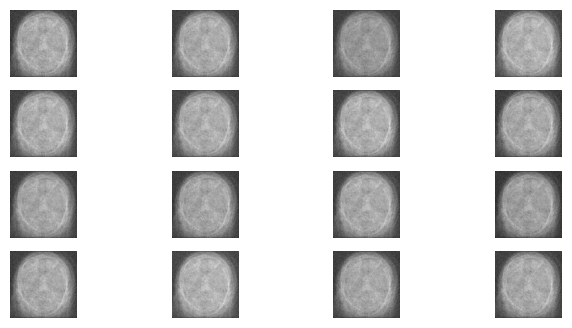

  3%|▎         | 1/30 [00:02<01:08,  2.35s/it]

Time for epoch 1 is 2.353790760040283 sec
Training started with epochs 2 with 10 bateches...
Losses after epoch     2: generator 1.497, discriminator 0.528,  real_score 94.15%, fake_score 30.98%


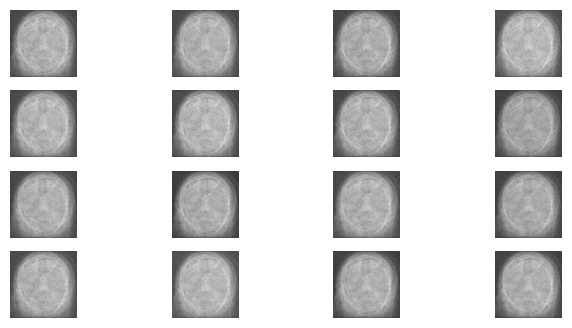

  7%|▋         | 2/30 [00:03<00:46,  1.66s/it]

Time for epoch 2 is 1.1633479595184326 sec
Training started with epochs 3 with 10 bateches...
Losses after epoch     3: generator 1.012, discriminator 0.955,  real_score 84.34%, fake_score 39.03%


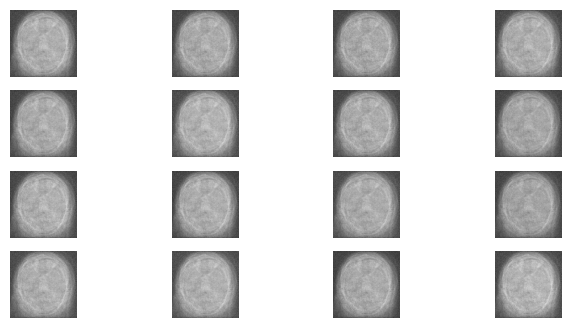

 10%|█         | 3/30 [00:04<00:34,  1.28s/it]

Time for epoch 3 is 0.8233726024627686 sec
Training started with epochs 4 with 10 bateches...
Losses after epoch     4: generator 2.484, discriminator 0.493,  real_score 84.56%, fake_score 17.02%


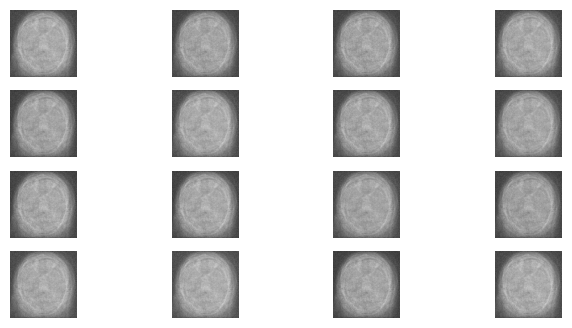

 13%|█▎        | 4/30 [00:05<00:28,  1.11s/it]

Time for epoch 4 is 0.8464710712432861 sec
Training started with epochs 5 with 10 bateches...
Losses after epoch     5: generator 0.933, discriminator 0.959,  real_score 85.55%, fake_score 43.30%


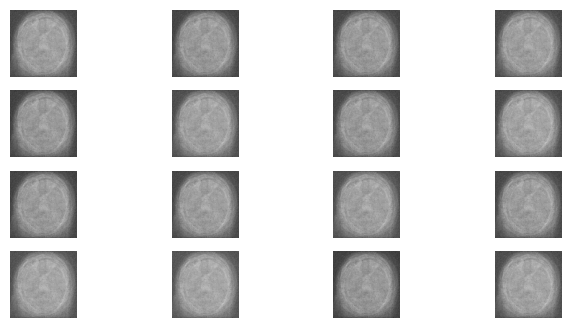

 17%|█▋        | 5/30 [00:06<00:25,  1.02s/it]

Time for epoch 5 is 0.8568084239959717 sec
Training started with epochs 6 with 10 bateches...
Losses after epoch     6: generator 1.948, discriminator 0.480,  real_score 88.92%, fake_score 21.83%


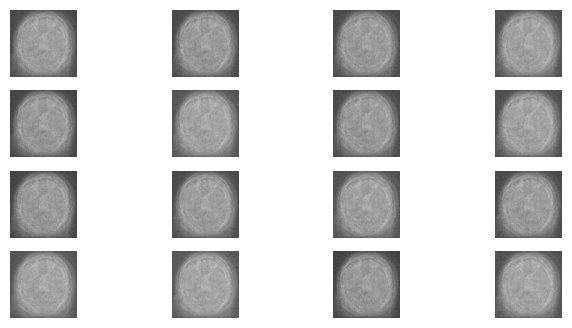

 20%|██        | 6/30 [00:07<00:25,  1.07s/it]

Time for epoch 6 is 1.1557729244232178 sec
Training started with epochs 7 with 10 bateches...
Losses after epoch     7: generator 1.476, discriminator 0.453,  real_score 93.55%, fake_score 28.08%


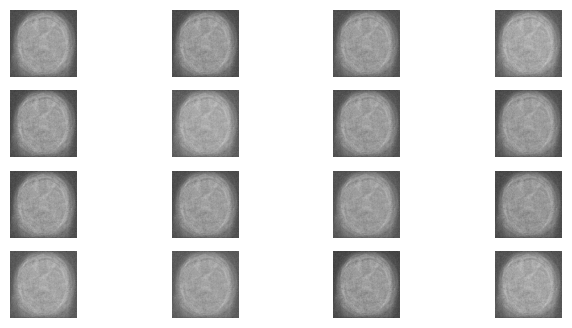

 23%|██▎       | 7/30 [00:08<00:22,  1.01it/s]

Time for epoch 7 is 0.8311753273010254 sec
Training started with epochs 8 with 10 bateches...
Losses after epoch     8: generator 1.470, discriminator 0.654,  real_score 90.97%, fake_score 30.09%


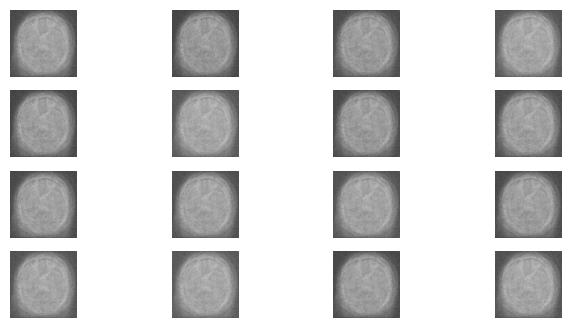

 27%|██▋       | 8/30 [00:09<00:22,  1.03s/it]

Time for epoch 8 is 1.110574722290039 sec
Training started with epochs 9 with 10 bateches...
Losses after epoch     9: generator 3.867, discriminator 0.231,  real_score 97.54%, fake_score 12.10%


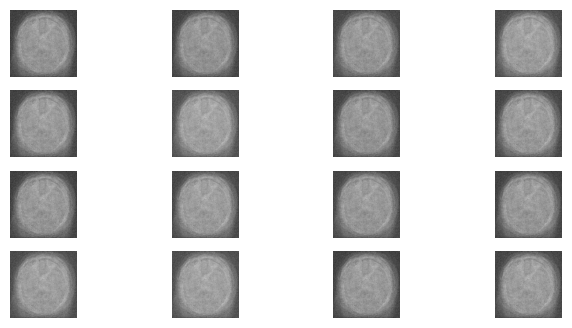

 30%|███       | 9/30 [00:10<00:23,  1.10s/it]

Time for epoch 9 is 1.2418615818023682 sec
Training started with epochs 10 with 10 bateches...
Losses after epoch    10: generator 2.003, discriminator 0.479,  real_score 85.10%, fake_score 17.62%


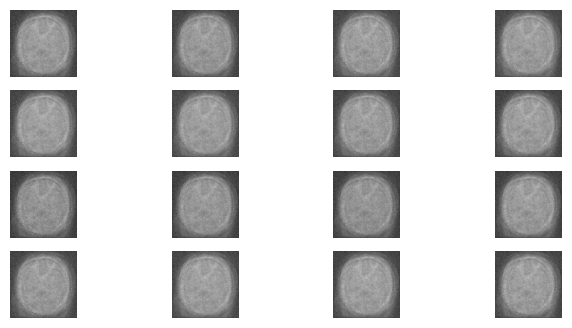

 33%|███▎      | 10/30 [00:12<00:25,  1.29s/it]

Time for epoch 10 is 1.7244701385498047 sec
Training started with epochs 11 with 10 bateches...
Losses after epoch    11: generator 2.262, discriminator 0.419,  real_score 93.99%, fake_score 20.42%


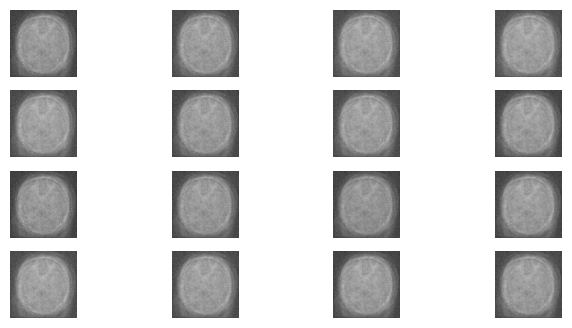

 37%|███▋      | 11/30 [00:13<00:23,  1.25s/it]

Time for epoch 11 is 1.1614558696746826 sec
Training started with epochs 12 with 10 bateches...
Losses after epoch    12: generator 0.847, discriminator 0.893,  real_score 92.36%, fake_score 47.42%


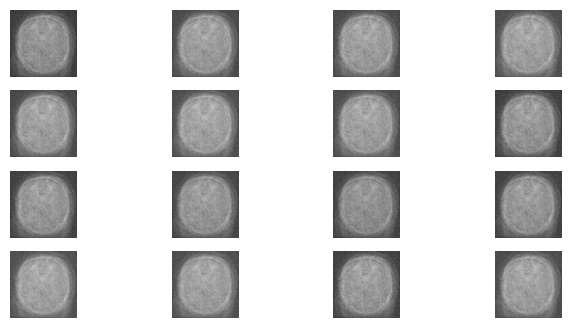

 40%|████      | 12/30 [00:14<00:20,  1.13s/it]

Time for epoch 12 is 0.8332571983337402 sec
Training started with epochs 13 with 10 bateches...
Losses after epoch    13: generator 1.470, discriminator 0.739,  real_score 91.94%, fake_score 34.77%


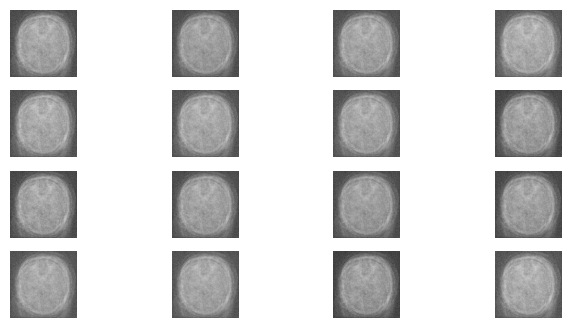

 43%|████▎     | 13/30 [00:14<00:17,  1.04s/it]

Time for epoch 13 is 0.8467068672180176 sec
Training started with epochs 14 with 10 bateches...
Losses after epoch    14: generator 5.148, discriminator 0.320,  real_score 90.69%, fake_score 8.58%


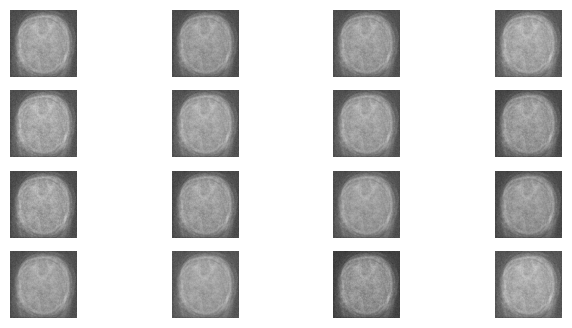

 47%|████▋     | 14/30 [00:15<00:15,  1.02it/s]

Time for epoch 14 is 0.8267099857330322 sec
Training started with epochs 15 with 10 bateches...
Losses after epoch    15: generator 1.047, discriminator 1.001,  real_score 85.37%, fake_score 41.17%


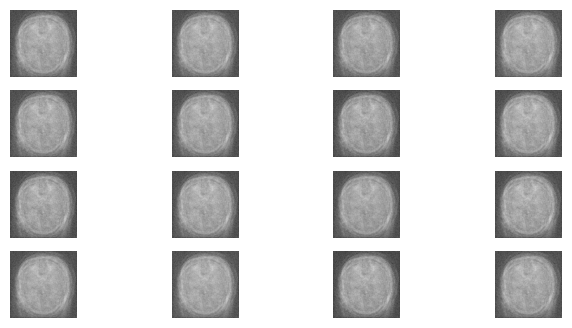

 50%|█████     | 15/30 [00:16<00:13,  1.08it/s]

Time for epoch 15 is 0.8105940818786621 sec
Training started with epochs 16 with 10 bateches...
Losses after epoch    16: generator 2.875, discriminator 0.430,  real_score 86.78%, fake_score 14.64%


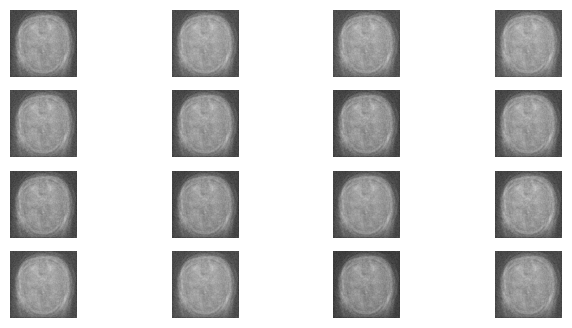

 53%|█████▎    | 16/30 [00:17<00:13,  1.00it/s]

Time for epoch 16 is 1.1526730060577393 sec
Training started with epochs 17 with 10 bateches...
Losses after epoch    17: generator 1.561, discriminator 0.553,  real_score 86.91%, fake_score 24.91%


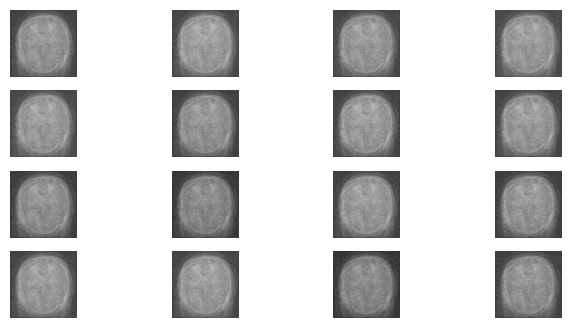

 57%|█████▋    | 17/30 [00:18<00:12,  1.05it/s]

Time for epoch 17 is 0.8507390022277832 sec
Training started with epochs 18 with 10 bateches...
Losses after epoch    18: generator 2.848, discriminator 0.554,  real_score 88.40%, fake_score 14.09%


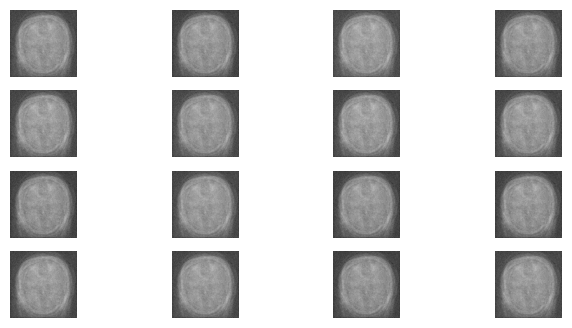

 60%|██████    | 18/30 [00:19<00:11,  1.07it/s]

Time for epoch 18 is 0.8700532913208008 sec
Training started with epochs 19 with 10 bateches...
Losses after epoch    19: generator 1.256, discriminator 0.511,  real_score 93.42%, fake_score 32.23%


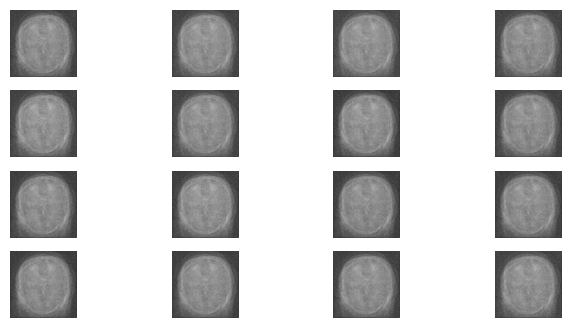

 63%|██████▎   | 19/30 [00:20<00:10,  1.07it/s]

Time for epoch 19 is 0.944739818572998 sec
Training started with epochs 20 with 10 bateches...
Losses after epoch    20: generator 3.261, discriminator 0.421,  real_score 90.81%, fake_score 15.80%


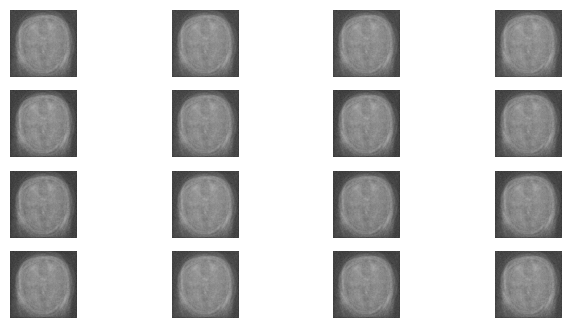

 67%|██████▋   | 20/30 [00:22<00:13,  1.33s/it]

Time for epoch 20 is 2.248913288116455 sec
Training started with epochs 21 with 10 bateches...
Losses after epoch    21: generator 1.711, discriminator 0.611,  real_score 86.49%, fake_score 24.66%


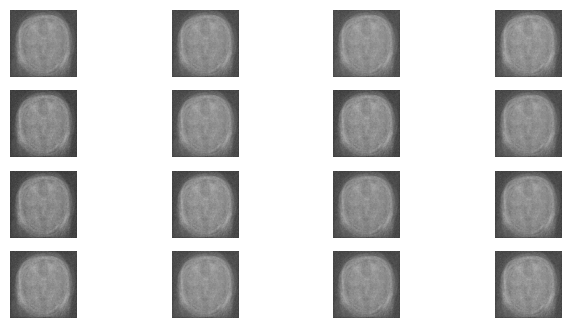

 70%|███████   | 21/30 [00:23<00:10,  1.18s/it]

Time for epoch 21 is 0.8388726711273193 sec
Training started with epochs 22 with 10 bateches...
Losses after epoch    22: generator 2.215, discriminator 0.523,  real_score 92.73%, fake_score 24.03%


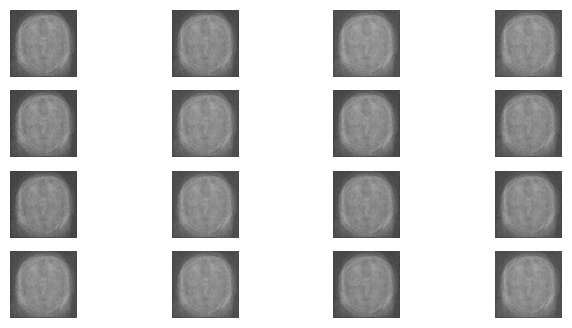

 73%|███████▎  | 22/30 [00:24<00:09,  1.22s/it]

Time for epoch 22 is 1.3058154582977295 sec
Training started with epochs 23 with 10 bateches...
Losses after epoch    23: generator 2.775, discriminator 0.574,  real_score 85.32%, fake_score 16.50%


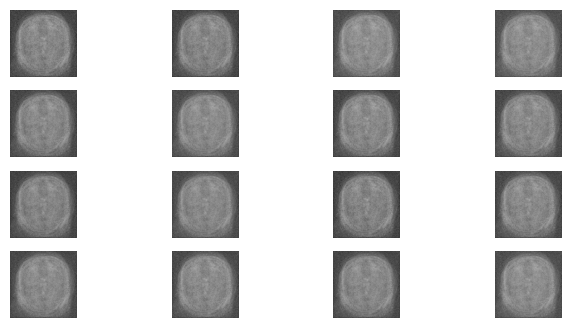

 77%|███████▋  | 23/30 [00:25<00:07,  1.11s/it]

Time for epoch 23 is 0.8406639099121094 sec
Training started with epochs 24 with 10 bateches...
Losses after epoch    24: generator 0.972, discriminator 0.947,  real_score 92.11%, fake_score 43.87%


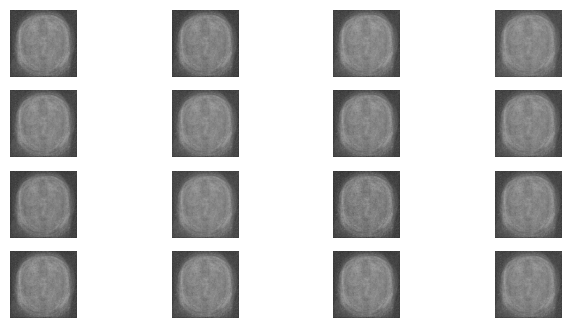

 80%|████████  | 24/30 [00:26<00:06,  1.03s/it]

Time for epoch 24 is 0.8484621047973633 sec
Training started with epochs 25 with 10 bateches...
Losses after epoch    25: generator 4.695, discriminator 0.209,  real_score 94.21%, fake_score 7.78%


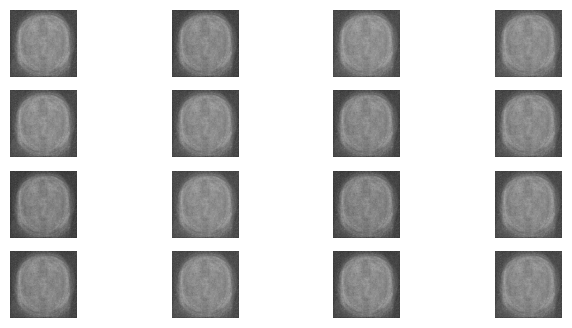

 83%|████████▎ | 25/30 [00:27<00:04,  1.02it/s]

Time for epoch 25 is 0.8554377555847168 sec
Training started with epochs 26 with 10 bateches...
Losses after epoch    26: generator 0.962, discriminator 0.833,  real_score 92.04%, fake_score 43.73%


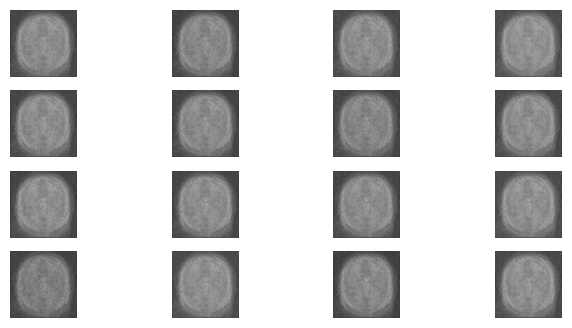

 87%|████████▋ | 26/30 [00:28<00:04,  1.04s/it]

Time for epoch 26 is 1.1641430854797363 sec
Training started with epochs 27 with 10 bateches...
Losses after epoch    27: generator 1.575, discriminator 0.897,  real_score 81.74%, fake_score 32.90%


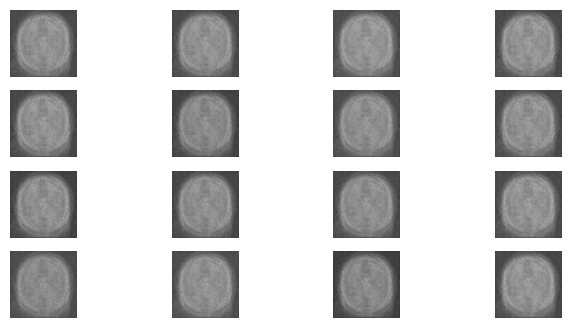

 90%|█████████ | 27/30 [00:29<00:03,  1.00s/it]

Time for epoch 27 is 0.9126453399658203 sec
Training started with epochs 28 with 10 bateches...
Losses after epoch    28: generator 3.931, discriminator 0.343,  real_score 86.02%, fake_score 8.13%


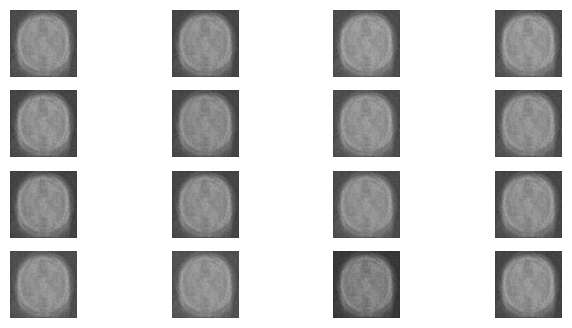

 93%|█████████▎| 28/30 [00:30<00:01,  1.03it/s]

Time for epoch 28 is 0.8876445293426514 sec
Training started with epochs 29 with 10 bateches...
Losses after epoch    29: generator 1.100, discriminator 0.882,  real_score 90.51%, fake_score 40.95%


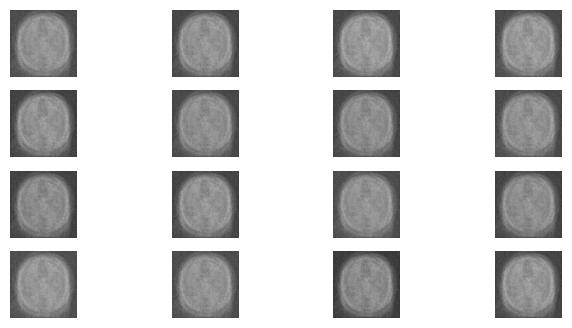

 97%|█████████▋| 29/30 [00:31<00:00,  1.08it/s]

Time for epoch 29 is 0.8273720741271973 sec
Training started with epochs 30 with 10 bateches...
Losses after epoch    30: generator 4.001, discriminator 0.302,  real_score 91.71%, fake_score 8.40%


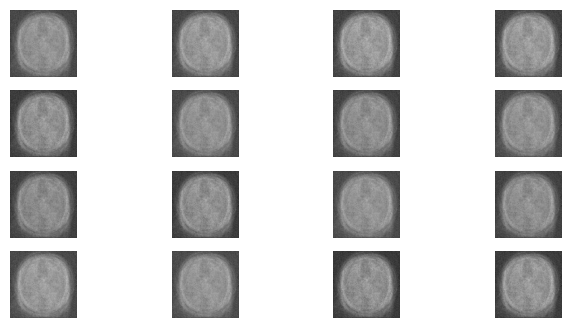

100%|██████████| 30/30 [00:33<00:00,  1.10s/it]

Time for epoch 30 is 1.870370626449585 sec


In [ ]:
from tqdm import tqdm
# start training process
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list=train(train_dataset,epochs=epochs)